# 1. Imports
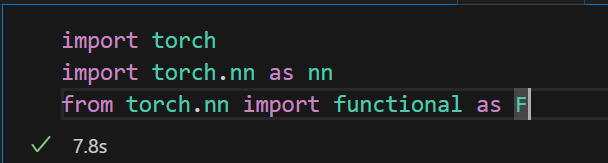

In [ ]:
# Import torch and nn

# 2. Assign Hyper Parameters

In [ ]:
# hyperparameters
batch_size = 32 # how many independent sequences will we process in parallel?
block_size = 8 # what is the maximum context length for predictions?
max_iters = 3000
eval_interval = 300
learning_rate = 1e-2
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200

# 3. Upload wizard_of_oz.txt from the repo, you are being shared

In [ ]:
from google.colab import files
uploaded = files.upload()

import os

with open('./wizard_of_oz.txt', 'r', encoding='utf-8') as f:
    text = f.read()
    print(text[:1000])

## Words to integer Conversion
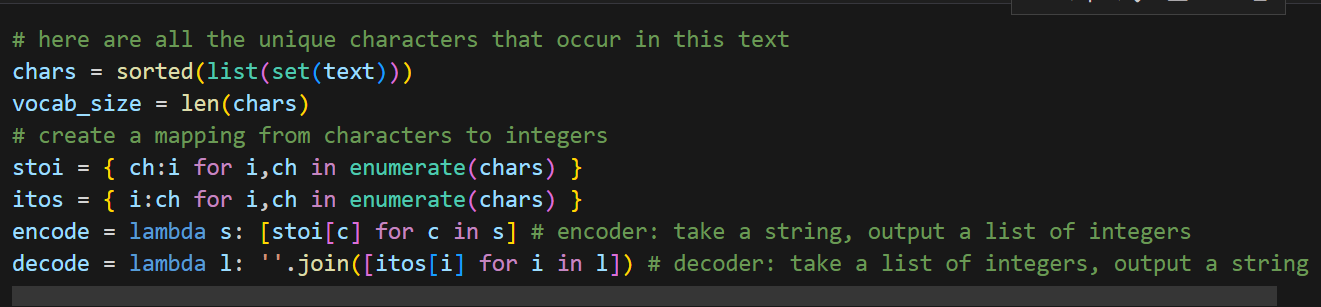

In [ ]:
# Create a encode and decode function

## Split Train and Test Data

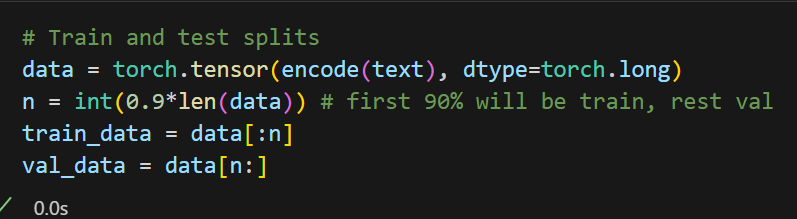

In [ ]:
# 90% training and 10% validation split




## Batch data and stack them for prediction
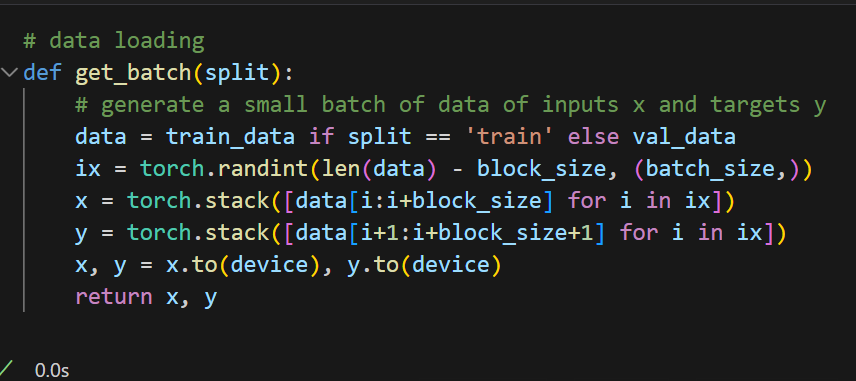

In [ ]:
# Split data as input and target z, z+1 -> x, y respectively




In [ ]:
# Function to estimate loss and run on every learning iteration
@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

## Complete BigramLM 

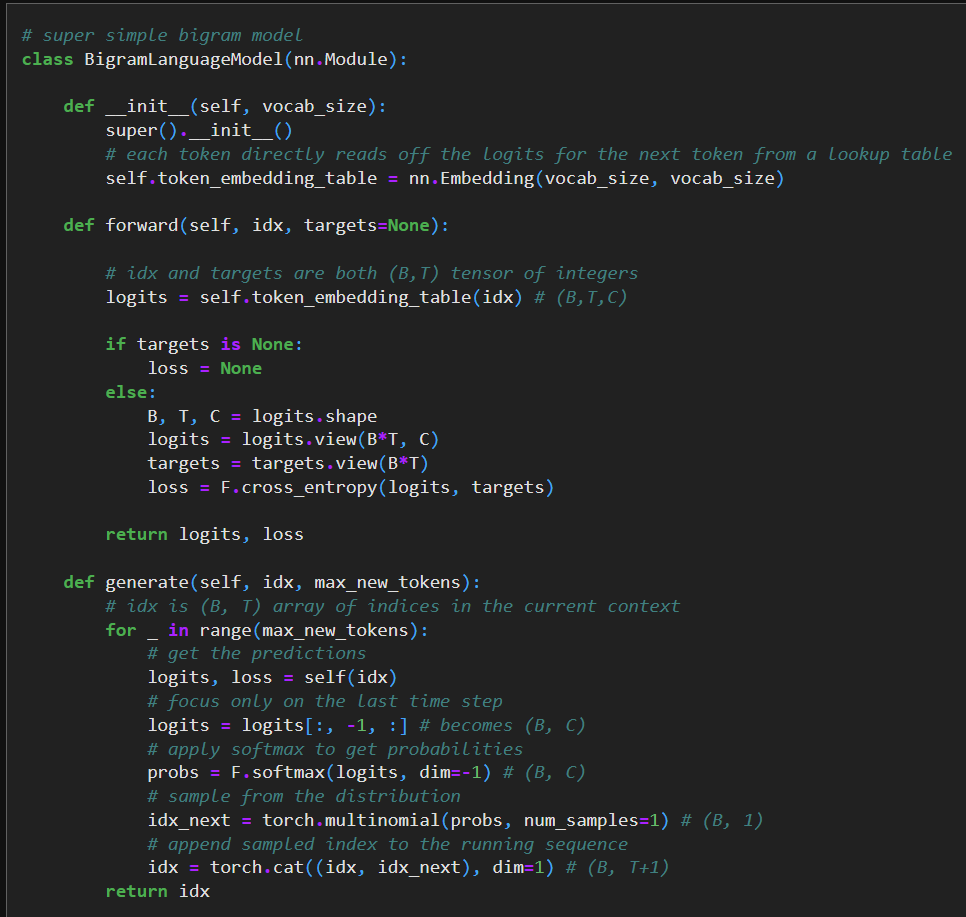

In [ ]:
# Run the model to get the output
model = BigramLanguageModel(vocab_size)
m = model.to(device)

# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

In [ ]:
# Training loop
for iter in range(max_iters):

    # every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0:
        losses = estimate_loss()
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

In [ ]:
# generate from the model
context = torch.zeros((1, 1), dtype=torch.long, device=device)
print(decode(m.generate(context, max_new_tokens=500)[0].tolist()))